In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

In [2]:
def getRanks(where, type_, class_):
    clss = soup.findAll(where, {type_:class_})
    toReturn = []
    for c in clss:
        ret = c.text.strip().replace('.', '')
        toReturn.append(int(ret))
        
    return toReturn

def getTitleLength(where, type_, class_):
    clss = soup.findAll(where, {type_:class_})
    toReturn = []
    for c in clss:
        ret = c.text.strip().replace('.', '')
        toReturn.append(len(ret))
        
    return toReturn


def getHours(where, type_, class_):
    clss = soup.findAll(where, {type_:class_})
    toReturn = []
    for c in clss:
        ret = c.text.strip().replace('.', '')
        if 'minute' in ret:
            minutes = float(ret[0:2])
            toReturn.append(minutes/60)
        elif 'day' in ret:
            days = float(ret[0:2])
            toReturn.append(days*24)
        else:
            toReturn.append(float(ret[0:2]))

    return toReturn


def getPoints():
    toReturn = []
    for c in soup.findAll(class_ = 'subtext'):
        score = c.find(class_ = 'score')
        if score is None:
            toReturn.append(0)
        else:
            ret = score.text.strip().replace('points', '')
            toReturn.append(int(ret))
        
    return toReturn


def getComments():
    toReturn = []
    for a in soup.findAll(class_= 'subtext'):
        ret = 0
        for c in a.findAll('a'):
            if 'comments' in c.text.strip():
                ret = c.text.strip().replace('comments', '')
        toReturn.append(int(ret))
    return toReturn

In [3]:
ranks = []
titles = []
hours = []
points = []
comments = []

urls = ["https://news.ycombinator.com/", "https://news.ycombinator.com/news?p=2", "https://news.ycombinator.com/news?p=3", "https://news.ycombinator.com/news?p=4", "https://news.ycombinator.com/news?p=5"]

for url in urls:
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    ranks.extend(getRanks("span", "class", "rank"))
    titles.extend(getTitleLength("a", "class", "storylink")) 
    hours.extend(getHours("span", "class", "age"))     
    points.extend(getPoints())
    comments.extend(getComments())

df = pd.DataFrame(list(zip(ranks, titles, hours, points, comments)), columns=["Ranks", "TitleLength", "Hours", "Points", "Comments"])

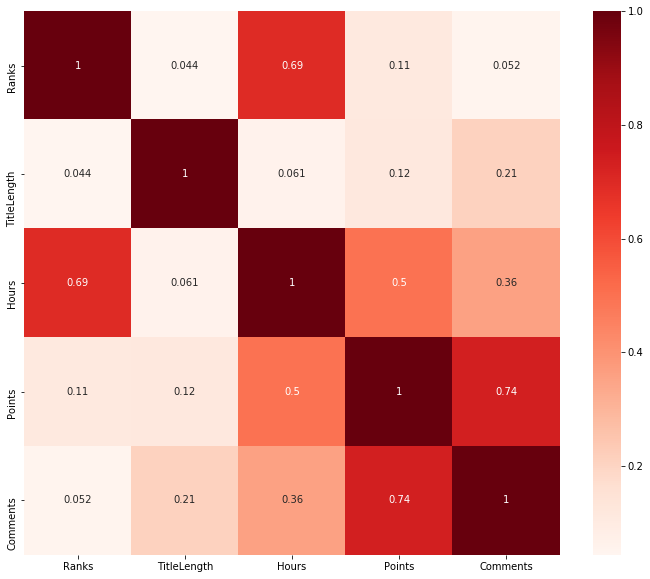

Best alpha using built-in LassoCV: 0.829747
Best score using built-in LassoCV: 0.558846
Lasso picked 4 variables and eliminated the other 0 variables


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0.5, 1.0, 'Feature importance using Lasso Model')

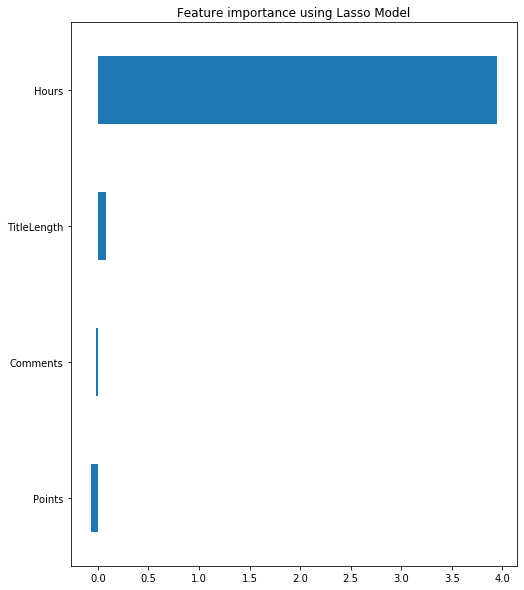

In [4]:
####################################################################################################
##Feature Selection and Regression
####################################################################################################
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

cor_target = abs(cor["Ranks"])
relevant_features = cor_target[cor_target>0.05]

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

x = df[["TitleLength", "Hours", "Points", "Comments"]]
y = df[['Ranks']]

reg = LassoCV()
reg.fit(x,y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(x,y))
coef = pd.Series(reg.coef_, index = x.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

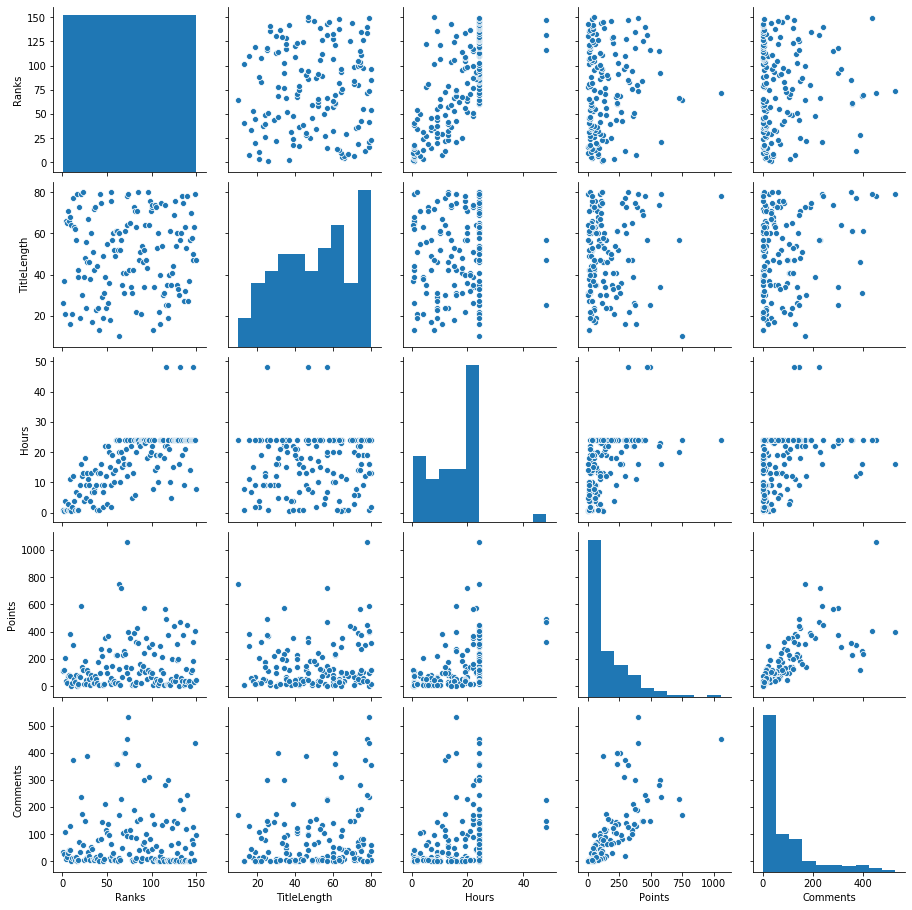

In [5]:
####################################################################################################
##Regression with statsmodels
####################################################################################################
import statsmodels.formula.api as smf
import statsmodels.api as sm

sns.pairplot(df)

                            OLS Regression Results                            
Dep. Variable:                  Ranks   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     138.1
Date:                Thu, 04 Jun 2020   Prob (F-statistic):           6.17e-23
Time:                        08:27:54   Log-Likelihood:                -728.64
No. Observations:                 150   AIC:                             1461.
Df Residuals:                     148   BIC:                             1467.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.9006      5.083      4.702      0.0

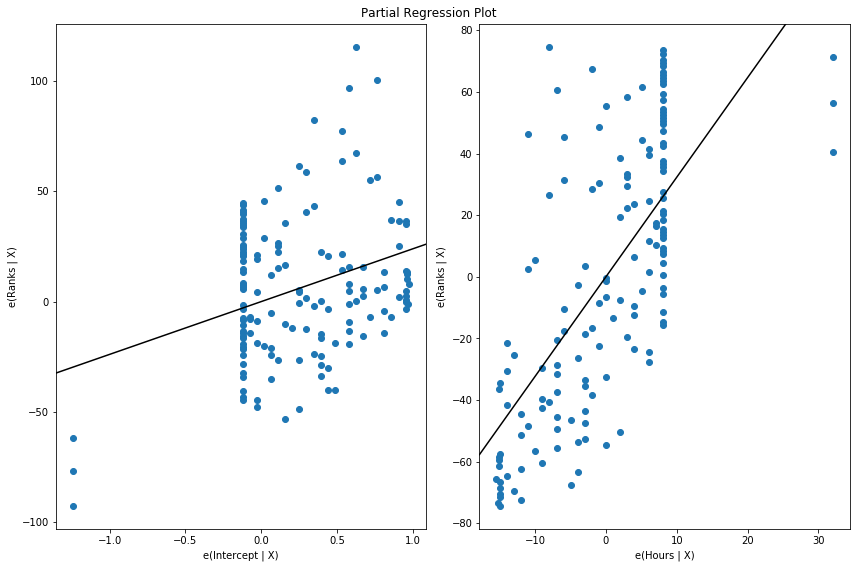

In [6]:
model1 = smf.ols(formula='Ranks ~ Hours', data=df)
res1 = model1.fit()
print(res1.summary())
fig1= plt.figure(figsize=(12,8))
fig1 = sm.graphics.plot_partregress_grid(res1, fig=fig1)

                            OLS Regression Results                            
Dep. Variable:                  Ranks   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     45.92
Date:                Thu, 04 Jun 2020   Prob (F-statistic):           7.09e-25
Time:                        08:27:54   Log-Likelihood:                -716.69
No. Observations:                 150   AIC:                             1443.
Df Residuals:                     145   BIC:                             1458.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      20.5026      7.664      2.675      

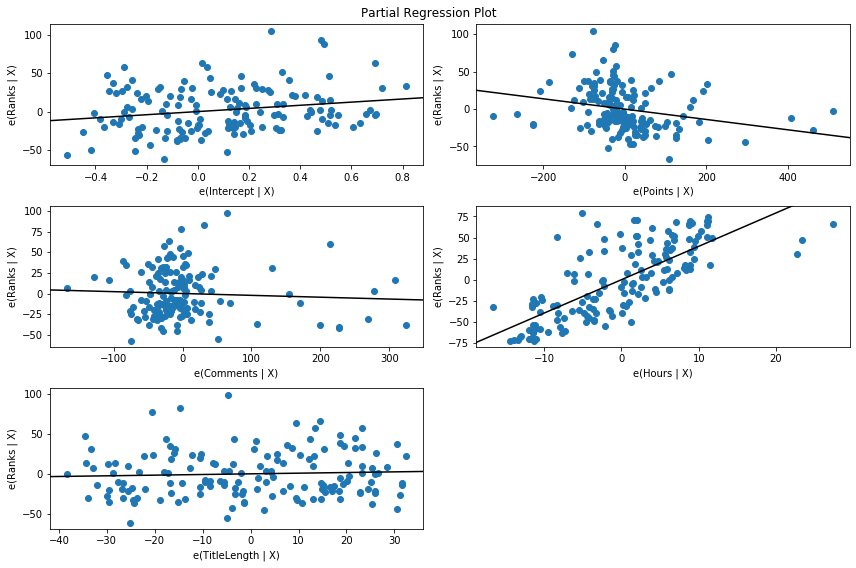

In [7]:
model2 = smf.ols(formula='Ranks ~ Points + Comments + Hours + TitleLength', data=df)
res2 = model2.fit()
print(res2.summary())
fig2 = plt.figure(figsize=(12,8))
fig2 = sm.graphics.plot_partregress_grid(res2, fig=fig2)

                            OLS Regression Results                            
Dep. Variable:                  Ranks   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     61.78
Date:                Thu, 04 Jun 2020   Prob (F-statistic):           7.60e-26
Time:                        08:27:55   Log-Likelihood:                -716.60
No. Observations:                 150   AIC:                             1441.
Df Residuals:                     146   BIC:                             1453.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       20.5151      6.042      3.395   

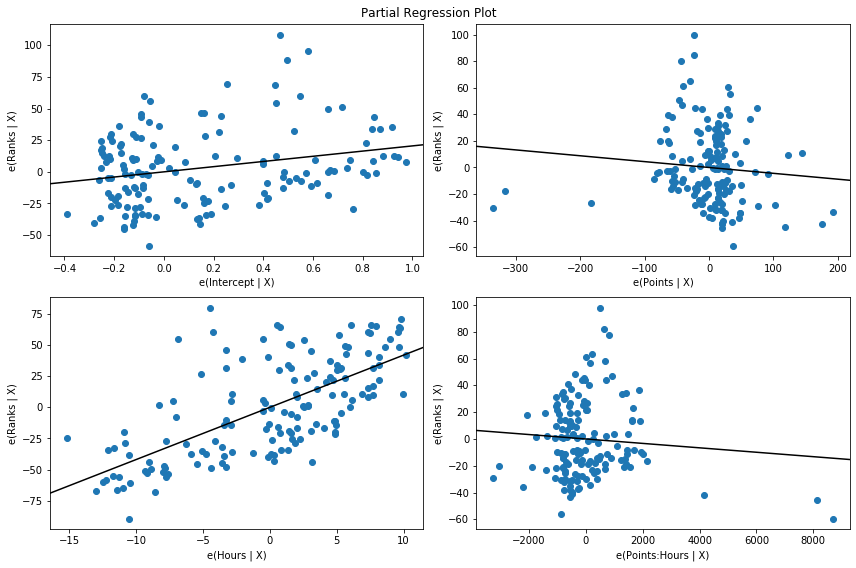

In [8]:
model3 = smf.ols(formula='Ranks ~ Points * Hours', data=df)
res3 = model3.fit()
print(res3.summary())
fig3 = plt.figure(figsize=(12,8))
fig3 = sm.graphics.plot_partregress_grid(res3, fig=fig3)

                            OLS Regression Results                            
Dep. Variable:                  Ranks   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     92.23
Date:                Thu, 04 Jun 2020   Prob (F-statistic):           1.11e-26
Time:                        08:27:55   Log-Likelihood:                -717.09
No. Observations:                 150   AIC:                             1440.
Df Residuals:                     147   BIC:                             1449.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.1796      4.723      5.120      0.0

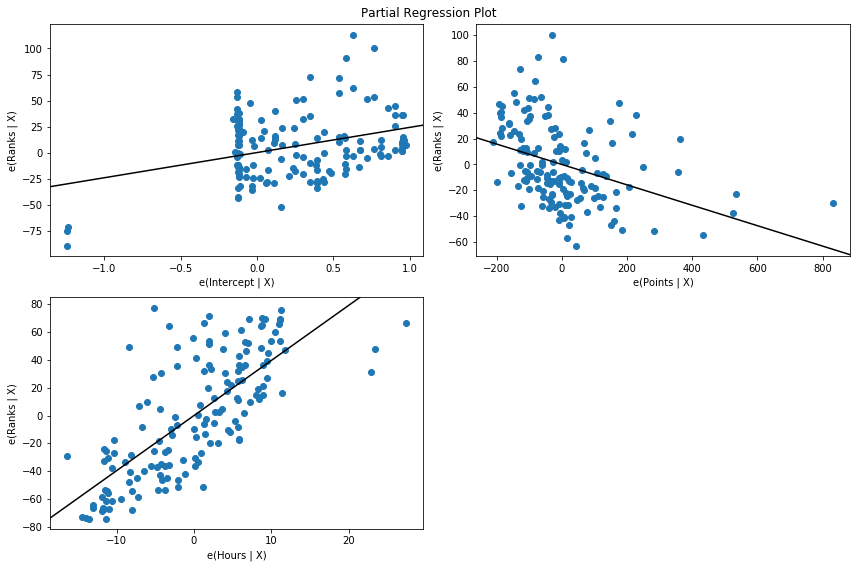

In [9]:
model4 = smf.ols(formula='Ranks ~ Points + Hours', data=df)
res4 = model4.fit()
print(res4.summary())
fig4 = plt.figure(figsize=(12,8))
fig4 = sm.graphics.plot_partregress_grid(res4, fig=fig4)

In [10]:
#Model 3 is the the best of my models, which is the iteraction of points and age

#The strongest linear relatioship is beteween points and comments

Optimization terminated successfully.
         Current function value: 0.346726
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              FrontPage   No. Observations:                  150
Model:                          Logit   Df Residuals:                      149
Method:                           MLE   Df Model:                            0
Date:                Thu, 04 Jun 2020   Pseudo R-squ.:                  0.3071
Time:                        08:27:55   Log-Likelihood:                -52.009
converged:                       True   LL-Null:                       -75.060
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Hours         -0.1402      0.021     -6.732      0.000      -0.181      -0.099


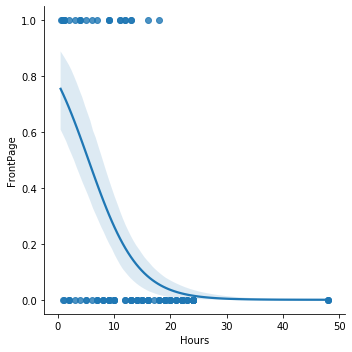

In [11]:
####################################################################################################
##Logistic Regression
####################################################################################################

df['FrontPage'] = pd.cut(df['Ranks'], bins=[0,30,150], right=True, labels=False).map({0:1, 1:0})
#exog = df[['Points', 'Hours', 'Comments', 'TitleLength']]
exog = df['Hours']
endog = df['FrontPage']
#logit = smf.logit('FrontPage ~ Points + Hours + Comments + TitleLength', data=df).fit()
logit = sm.Logit(endog, exog).fit()
print(logit.summary())
pred = logit.predict(exog)
logit.pred_table()
sns.lmplot(x='Hours', logistic=True, y='FrontPage', data=df)

#My regressions don't tell me much about making the front page except that it is better to have a low age.

In [12]:
####################################################################################################
##Random Forests - just to see
####################################################################################################
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(x, endog, test_size=0.3)
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print("Random Forest Accuracy:",metrics.accuracy_score(y_test, y_pred))

conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

Random Forest Accuracy: 0.7555555555555555
[[31  5]
 [ 6  3]]
